## Configuración de las capas del Discriminador: 28px, 64px

In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
print(os.getcwd())
currentPath = os.getcwd().split('/')

indexOf = currentPath.index('CDCGAN')
rootPath = '/'.join(currentPath[:indexOf+1])
os.chdir(rootPath)
root = os.getcwd()

print(os.getcwd())

/workspace/CDCGAN/packages/arquitectures/networks
/workspace/CDCGAN


In [3]:
from packages.arquitectures.networks.Discriminator import DiscriminatorMannager
from packages.dataHandlers.datasetMannager import datasetMannager

In [4]:
def _inputDis(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, 
            kernel_size=kernel_size, stride=stride, padding=padding, 
            bias=False),
        nn.LeakyReLU(0.2, inplace=True)
)

def _blockDis(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, 
            kernel_size=kernel_size, stride=stride, padding=padding, 
            bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True)
    )

def _outputDis(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, 
            kernel_size=kernel_size, stride=stride, padding=padding, 
            bias=False), 
        nn.Sigmoid()
    )


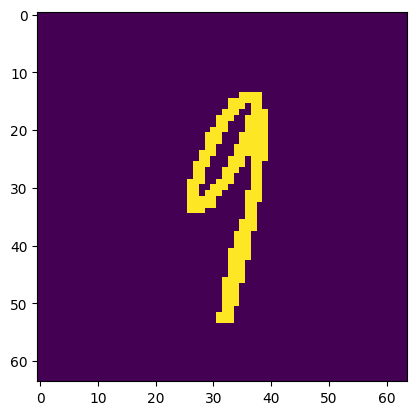

Label: q
input = torch.Size([128, 1, 64, 64]) - torch.Size([128, 24, 64, 64])
----------------------
_l0 = torch.Size([128, 128, 32, 32])
_l1 = torch.Size([128, 256, 16, 16])
_l2 = torch.Size([128, 512, 8, 8])
_l3 = torch.Size([128, 1024, 4, 4])
_l4 = torch.Size([128, 1, 1, 1])
----------------------
output = torch.Size([1, 1, 1])


In [5]:
class ConditionalDiscriminator64(nn.Module):
    def __init__(self, features_d = 64, channels = 1, labels = 10):
        super(ConditionalDiscriminator64, self).__init__()
        
        self.layer_x = _inputDis(channels, features_d, kernel_size=4, stride=2, padding=1)        
        self.layer_y = _inputDis(labels, features_d, kernel_size=4, stride=2, padding=1)	        
        
        self.layer_1 = _blockDis(features_d*2, features_d*4, kernel_size=3, stride=2, padding=1)  
        self.layer_2 = _blockDis(features_d*4, features_d*8, kernel_size=3, stride=2, padding=1)
        self.layer_3 = _blockDis(features_d*8, features_d*16, kernel_size=3, stride=2, padding=1)
        self.layer_4 = _outputDis(features_d*16, channels, kernel_size=4, stride=1, padding=0)     
        

    def forward(self, x, y):
        print(f"input = {x.shape} - {y.shape}")
        print("----------------------")

        lx, ly = self.layer_x(x), self.layer_y(y)
        l0 = torch.cat([lx,ly], dim=1)
        print(f"_l0 = {l0.shape}") 

        l1 = self.layer_1(l0)
        print(f"_l1 = {l1.shape}") 
        
        l2 = self.layer_2(l1)
        print(f"_l2 = {l2.shape}")

        l3 = self.layer_3(l2)
        print(f"_l3 = {l3.shape}")
        
        l4 = self.layer_4(l3)
        print(f"_l4 = {l4.shape}")

        print("----------------------")
        print(f"output = {l4.shape[1:]}")

        return l4.view(l4.shape[0], -1)
        

DATASET_NAME = "LETTERS"
BATCH_SIZE = 128
IMG_CHANNELS = 1
IMG_SIZE = 64
Z_SIZE = 100

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=IMG_CHANNELS),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataHandler_64 = datasetMannager(transform, BATCH_SIZE, DATASET_NAME)
data_module_64 = dataHandler_64.getDataModule()
# data_module.displaySamples()

DATALOADER_64 = data_module_64.getTrainDataLoader()
UNIQUE_LABELS = data_module_64.getUniqueLabels()
LABELS_COUNT = UNIQUE_LABELS.shape[0]
FILL = torch.zeros([LABELS_COUNT, LABELS_COUNT, IMG_SIZE, IMG_SIZE])

img,label = next(iter(DATALOADER_64))
data_module_64.displayImage(img, label)

dis_64 = ConditionalDiscriminator64(IMG_SIZE, 1, LABELS_COUNT)
output = dis_64(img, FILL[label])

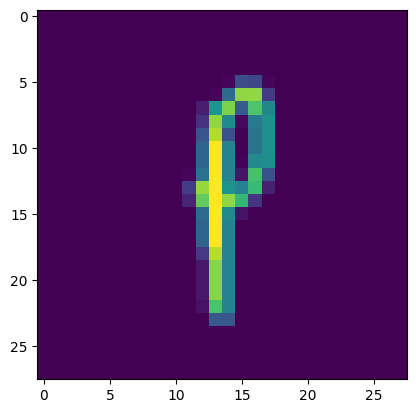

Label: p
input = torch.Size([128, 1, 28, 28]) - torch.Size([128, 24, 28, 28])
----------------------
_lx= torch.Size([128, 28, 14, 14]), ly= torch.Size([128, 28, 14, 14]))
_l1 = torch.Size([128, 112, 7, 7])
_l2 = torch.Size([128, 224, 3, 3])
_l3 = torch.Size([128, 1, 1, 1])
----------------------
output = torch.Size([128, 1, 1, 1])
torch.Size([128, 1])


In [6]:
class ConditionalDiscriminator28(nn.Module):
    def __init__(self, features_d = 64, channels = 1, labels = 10):
        super(ConditionalDiscriminator28, self).__init__()
        
        self.layer_x = _inputDis(channels, features_d, kernel_size=4, stride=2, padding=1)        # input: (1, 28, 28) 	=> 	out: (32, 14, 14)
        self.layer_y = _inputDis(labels, features_d, kernel_size=4, stride=2, padding=1)	        # input: (10, 28, 28) 	=> 	out: (32, 14, 14)
        
        self.layer_1 = _blockDis(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1)  # input: (64, 14, 14)	=> 	out: (128, 7, 7) 
        self.layer_2 = _blockDis(features_d*4, features_d*8, kernel_size=3, stride=2, padding=0)  # input: (128, 7, 7) 	=> 	out: (256, 3, 3)
        self.layer_3 = _outputDis(features_d*8, channels, kernel_size=3, stride=1, padding=0)         
        
    def forward(self, x, y):
        print(f"input = {x.shape} - {y.shape}")
        print("----------------------")

        lx, ly = self.layer_x(x), self.layer_y(y)
        print(f"_lx= {lx.shape}, ly= {ly.shape})")
        
        l1 = self.layer_1(torch.cat([lx,ly], dim=1)) # size of xy : (batch_size, 64, 14, 14)
        print(f"_l1 = {l1.shape}") 
        
        l2 = self.layer_2(l1)
        print(f"_l2 = {l2.shape}")
        
        l3 = self.layer_3(l2)
        print(f"_l3 = {l3.shape}")

        print("----------------------")
        out = l3.view(l3.shape[0], -1)
        print(f"output = {l3.shape}")

        return out
        
DATASET_NAME = "LETTERS"
BATCH_SIZE = 128
IMG_CHANNELS = 1
IMG_SIZE = 28
Z_SIZE = 100

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=IMG_CHANNELS),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataHandler_28 = datasetMannager(transform, BATCH_SIZE, DATASET_NAME)
data_module_28 = dataHandler_28.getDataModule()
# data_module.displaySamples()

DATALOADER_64 = data_module_28.getTrainDataLoader()
UNIQUE_LABELS = data_module_28.getUniqueLabels()
LABELS_COUNT = UNIQUE_LABELS.shape[0]
FILL = torch.zeros([LABELS_COUNT, LABELS_COUNT, IMG_SIZE, IMG_SIZE])

img,label = next(iter(DATALOADER_64))
data_module_28.displayImage(img, label)

dis_28 = ConditionalDiscriminator28(IMG_SIZE, 1, LABELS_COUNT)
output = dis_28(img, FILL[label])
print(output.shape)